In [83]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler   # u otros scalers
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, LassoCV, RidgeCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, r2_score
from distancia import haversine

In [84]:
### carga datos de dataset en dataframe
file_path= 'uber_fares.csv'

df = pd.read_csv(file_path)

In [85]:
### visualizacion de algunos datos
df.head()

,key,date,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


#### Contexto  
El proyecto trata sobre **Uber Inc.**, la compañía de taxis más grande del mundo. En este trabajo, nuestro objetivo es **predecir la tarifa de futuros viajes**.  

Uber brinda servicio a millones de clientes cada día, por lo que gestionar adecuadamente sus datos es clave para desarrollar nuevas estrategias de negocio y obtener mejores resultados.  

### Variables del conjunto de datos  

**Variables explicativas:**  
- **key**: identificador único de cada viaje.  
- **pickup_datetime**: fecha y hora en que se inició el viaje.  
- **passenger_count**: cantidad de pasajeros en el vehículo (dato ingresado por el conductor).  
- **pickup_longitude**: longitud del punto de inicio del viaje.  
- **pickup_latitude**: latitud del punto de inicio del viaje.  
- **dropoff_longitude**: longitud del punto de destino.  
- **dropoff_latitude**: latitud del punto de destino.  

**Variable objetivo (target):**  
- **fare_amount**: costo del viaje en dólares.  

In [86]:
### Columnas, ¿cuáles son variables numéricas y cuales variables categóricas?
df.columns

Index(['key', 'date', 'fare_amount', 'pickup_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count'],
      dtype='object')

En este dataset trabajaremos con algunas columnas de interes, las cuales clasificamos a continuacion dependiendo el tipo de variable:

*   **fare_amount:**   cuantitativa continua
*   **pickup_datetime:** cualitativa nominal
*   **pickup_longitude:** cuantitativa continua
*   **pickup_latitude:** cuantitativa continua
*   **dropoff_longitude:** cuantitativa continua
*   **dropoff_latitude:** cuantitativa continua
*   **passenger_count:** cuantitativa discreta

Lo primero que realizaremos será utilizar el método `.info()` para verificar que el tipo de dato en cada variable es correcto, detectar la presencia de valores nulos y valores atípicos.

In [87]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='fare_amount'), df['fare_amount'], test_size=0.2, random_state=42)

In [88]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 160000 entries, 153248 to 121958
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   key                160000 non-null  int64  
 1   date               160000 non-null  object 
 2   pickup_datetime    160000 non-null  object 
 3   pickup_longitude   160000 non-null  float64
 4   pickup_latitude    160000 non-null  float64
 5   dropoff_longitude  159999 non-null  float64
 6   dropoff_latitude   159999 non-null  float64
 7   passenger_count    160000 non-null  int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 11.0+ MB


In [89]:
# mostrar la fila con valores nulos
X_train[X_train.isnull().any(axis=1)]

,key,date,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
87946,32736015,2013-07-02 03:51:57.0000001,2013-07-02 03:51:57 UTC,-73.950581,40.779692,NaN,NaN,0


### Limpieza de los datos
Podemos observar a traves del 'X_train.info' que tenemos 200.000 datos donde las columnas 'dropoff_longitude' y 'dropoff_latitude' poseen un valor faltante en sus datos. Consideramos que al tener una muestra de datos abundante, decidimos eliminarlos del dataset ya que no afecta al entrenamiento del modelo y evitar imputar los datos con un valor promedio. Además, modificamos el tipo de dato de 'pickup_datetime' para verificar que todas las fechas ingresadas hayan sido correctamente cargadas.

In [90]:
# Cambia el tipo de dato object -> datetime
X_train['pickup_datetime'] = pd.to_datetime(X_train['pickup_datetime'])                   
# Elimina las filas con valores nulos
#X_train.dropna(inplace=True)     #No haria falta lo hacemos con imputacion

# Eliminación de columnas que no son de interes
X_train = X_train.drop('key', axis = 1)
X_train = X_train.drop('date', axis = 1)

Luego de esto, realizamos un '.describe()' sobre las variables numericas y consideramos los resultados para analizar cada variable del dataset.

In [91]:
X_train.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,160000.000000,160000.000000,159999.000000,159999.000000,160000.000000
mean,-72.525896,39.936265,-72.525260,39.919258,1.684988
std,11.557753,8.090121,13.611271,6.880320,1.405686
min,-1340.648410,-74.015515,-3356.666300,-881.985513,0.000000
25%,-73.992062,40.734842,-73.991433,40.733835,1.000000
50%,-73.981834,40.752594,-73.980080,40.753044,1.000000
75%,-73.967212,40.767116,-73.963614,40.768055,2.000000
max,57.418457,1644.421482,1153.572603,872.697628,208.000000


##### **Análisis de la columna `passenger_count`:**

A partir del análisis exploratorio mediante `.describe()`, se detectó que el valor máximo registrado en la variable fue de 208 pasajeros por viaje, lo cual constituye un error en la carga de datos. Para visualizar la distribución se realizaron diferentes gráficos:  

- En el **primer boxplot**, se observa claramente el valor atípico de 208, lo que impide una correcta interpretación del resto de los datos.  
- Al excluir dicho valor extremo, el **segundo boxplot** permite observar mejor la dispersión real de la variable.  

Además, se identificaron registros con 0 pasajeros, los cuales también son inconsistentes, ya que un viaje no puede realizarse sin pasajeros.  


<span style="color: red;">quizas deberiamos calcular los valores atipicos con q1 y q3 como en distancia??</span>

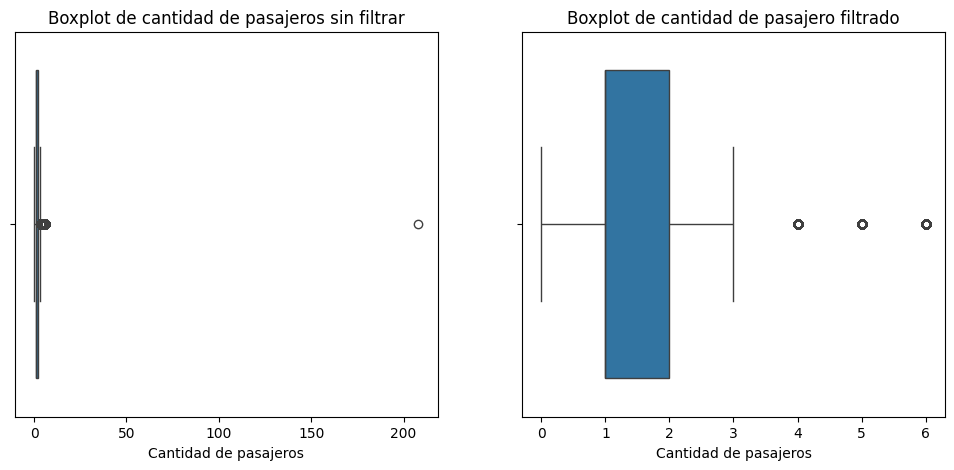

In [92]:
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
sns.boxplot(x = X_train['passenger_count'])
plt.title('Boxplot de cantidad de pasajeros sin filtrar')
plt.xlabel('Cantidad de pasajeros')

plt.subplot(1, 2, 2)
sns.boxplot(x = X_train[X_train['passenger_count'] < 208]['passenger_count'])
plt.title('Boxplot de cantidad de pasajero filtrado')
plt.xlabel('Cantidad de pasajeros')

plt.show()

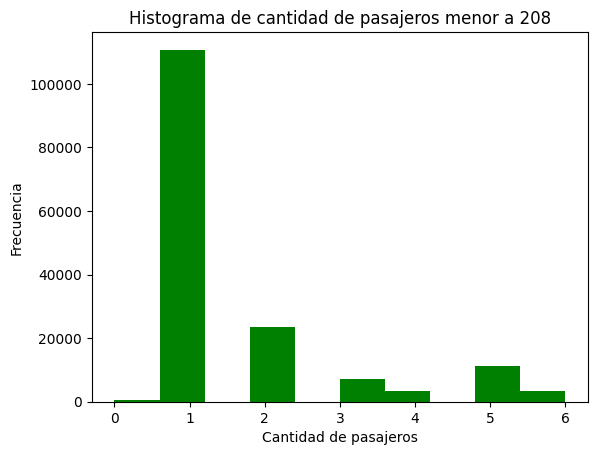

In [93]:
plt.hist(X_train[X_train['passenger_count'] < 208]['passenger_count'], color = 'green')
plt.title('Histograma de cantidad de pasajeros menor a 208')
plt.xlabel('Cantidad de pasajeros')
plt.ylabel('Frecuencia')
plt.show()

Para solucionar este problema y no eliminar dichos registros, se decidió imputar el valor atípico de 208 y tratar los datos con 0 pasajeros con la **mediana de la distribución**. La mediana es la medida de tendencia central y es robusta frente a valores atípicos y representa de forma adecuada la cantidad más común de pasajeros en los viajes (generalmente 1). Finalmente, la columna fue convertida a valores enteros para mantener consistencia en la variable.


In [94]:
from sklearn.impute import SimpleImputer

X_train.loc[X_train['passenger_count'] == 208, 'passenger_count'] = pd.NA
X_train.loc[X_train['passenger_count'] == 0, 'passenger_count'] = pd.NA
imputer = SimpleImputer(strategy='median')                                      # Imputar con la mediana
X_train['passenger_count'] = imputer.fit_transform(X_train[['passenger_count']])
X_train['passenger_count'] = X_train['passenger_count'].astype(int)

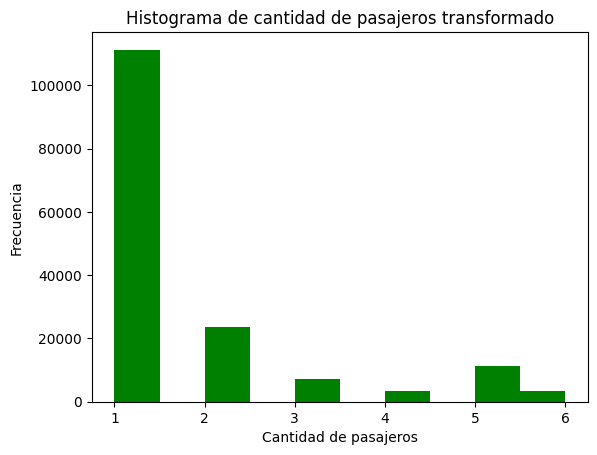

In [95]:
plt.hist(X_train['passenger_count'], color = 'green')
plt.title('Histograma de cantidad de pasajeros transformado')
plt.xlabel('Cantidad de pasajeros')
plt.ylabel('Frecuencia')
plt.show()

##### Análisis de las columnas `pickup_latitude`, `dropoff_latitude`, `pickup_longitude` y `dropoff_longitude`

Para analizar estos datos, lo primero que realizamos fue la visualización gráfica de cada variable. En estas gráficas se observan bastantes valores atípicos que no corresponden a rangos válidos de latitud y longitud:  

- **Rangos globales válidos**:  
  - Latitud: -90 a 90  
  - Longitud: -180 a 180  

Vamos a considerar las coordenadas que caigan dentro de estos rangos o bien tengan una sola coordenada de las 4 posibles fuera del rango.
En estos casos imputariamos la coordenada invalida con KNN

<span style="color: red;">Esto no lo pondria, porque esto seria una suposicion nuestra</span>
- **Rangos aproximados para New York**:  
  - Latitud: 40.50 a 41.00  
  - Longitud: -74.20 a -73.60  

De esta manera, se eliminan registros con coordenadas fuera de este rango, ya que son considerados como datos no representativos de la zona de análisis.

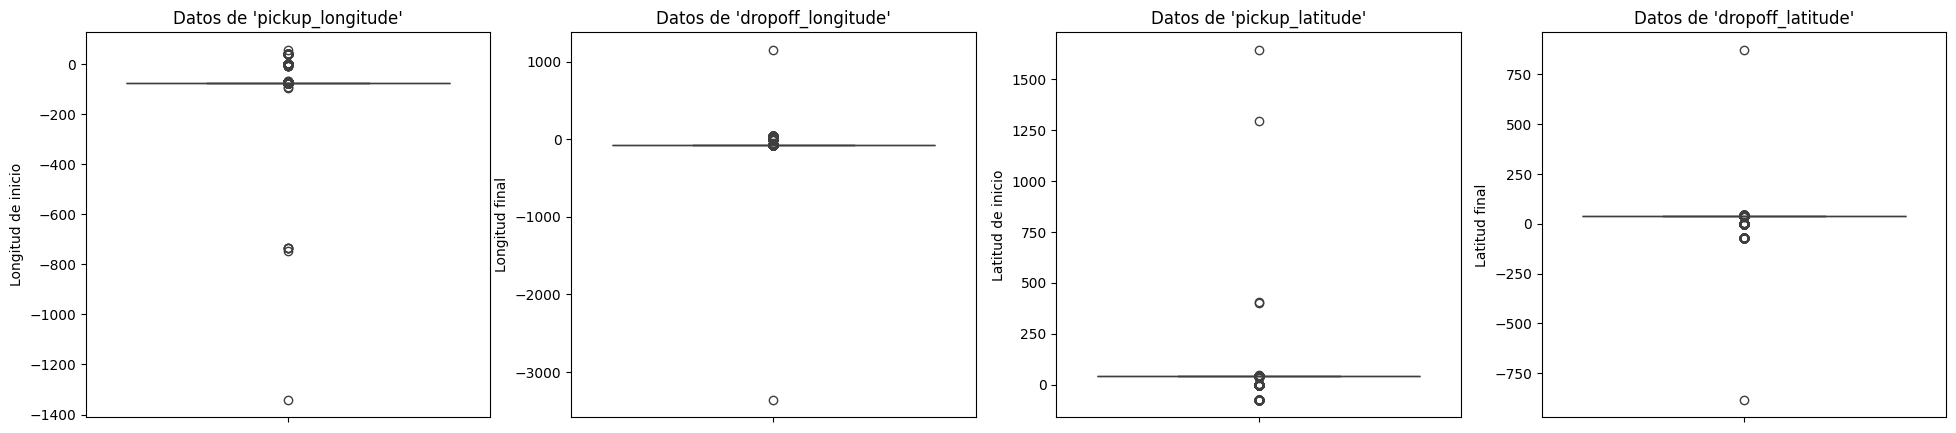

In [96]:
plt.figure(figsize=(24,5))

plt.subplot(1, 4, 1)
plt.title("Datos de 'pickup_longitude'")
sns.boxplot(X_train['pickup_longitude'])
plt.ylabel('Longitud de inicio')

plt.subplot(1, 4, 2)
plt.title("Datos de 'dropoff_longitude'")
sns.boxplot(X_train['dropoff_longitude'])
plt.ylabel('Longitud final')

plt.subplot(1, 4, 3)
plt.title("Datos de 'pickup_latitude'")
sns.boxplot(X_train['pickup_latitude'])
plt.ylabel('Latitud de inicio')

plt.subplot(1, 4, 4)
plt.title("Datos de 'dropoff_latitude'")
sns.boxplot(X_train['dropoff_latitude'])
plt.ylabel('Latitud final')

plt.show()

In [ ]:
# Esto creo que lo podemos quitar

# longitud = df[(df['pickup_longitude'] == 0.00) & (df['dropoff_longitude'] == 0.00)].value_counts().sum()  # 3587 datos
# latitud = df[(df['pickup_longitude'] == 0.00) & (df['dropoff_longitude'] == 0.00)].value_counts().sum()   # 3587 datos
# lat_long = df[(df['pickup_latitude'] == 0.00) & (df['dropoff_latitude'] == 0.00) & (df['pickup_longitude'] == 0.00) & (df['dropoff_longitude'] == 0.00)].value_counts().sum()
# print(f'datos nulos en latitud y longitud: {lat_long}') # 3587 datos
# print(f'datos nulos en longitud: {longitud}')
# print(f'datos nulos en latitud: {latitud}\n')

# longitud1 = df[df['dropoff_longitude'] == 0.00].value_counts().sum()  # 177 datos
# longitud2 = df[df['pickup_longitude'] == 0.00].value_counts().sum()   # 199 datos 
# latitud1 = df[(df['pickup_latitude'] == 0.00)].value_counts().sum()   # 177 datos 
# latitud2 = df[(df['dropoff_latitude'] == 0.00)].value_counts().sum()  # 171 datos 
# print(f'datos nulos en longitud inicio: {longitud2}')
# print(f'datos nulos en longitud final: {longitud1}')
# print(f'datos nulos en latitud inicio: {latitud1}')
# print(f'datos nulos en latitud final: {latitud2}\n')

Podemos observar que existen registros en los cuales tanto la latitud como la longitud (de inicio y de destino) tienen valor igual a 0. Estos registros no aportan información relevante al análisis, ya que corresponden a errores de carga, por lo que se decidió **eliminarlos del dataset** para trabajar únicamente con datos reales.  

Por otro lado, aquellos registros en los que solo **una de las coordenadas** (latitud o longitud, ya sea en inicio o destino) tiene valor igual a 0, pueden ser imputados por aproximación. En este caso, en lugar de eliminarlos, se optó por reemplazar dichos valores utilizando el método de imputación por K-vecinos más cercanos (KNN), lo cual permite estimar las coordenadas faltantes en base a los viajes más similares.

In [ ]:
# X_train[(X_train['pickup_latitude'] == 0.00) &(X_train['dropoff_latitude'] == 0.00) &(X_train['pickup_longitude'] == 0.00) &(X_train['dropoff_longitude'] == 0.00)].head()

In [ ]:
# Eliminar filas con todas las coordenadas en 0
#indices_invalidos = X_train[(X_train['pickup_latitude'] == 0.00) &(X_train['dropoff_latitude'] == 0.00) &(X_train['pickup_longitude'] == 0.00) &(X_train['dropoff_longitude'] == 0.00)].index
#X_train = X_train.drop(indices_invalidos)
# Cantidad de filas eliminadas
#print(f'Cantidad de filas eliminadas: {len(indices_invalidos)}')

In [97]:
# recorrer el dataset X_train y chequear si las coordenadas son validas o cero o nan y si no los son reemplazarlas con NaN
# si una fila tiene mas de 1 coordenada invalida, eliminar la fila
# mostrar la cantidad de filas eliminadas
# mostrar la cantidad de filas modificadas a NaN

modified_count = 0
initial_rows = X_train.shape[0] # cantidad inicial de filas
for index, row in X_train.iterrows():
    invalid_count = 0

    if not (-90 <= row['pickup_latitude'] <= 90) or row['pickup_latitude'] == 0.0 or pd.isna(row['pickup_latitude']): 
        X_train.at[index, 'pickup_latitude'] = pd.NA
        invalid_count += 1
    if not (-90 <= row['dropoff_latitude'] <= 90 or row['dropoff_latitude'] == 0.0) or pd.isna(row['dropoff_latitude']):
        X_train.at[index, 'dropoff_latitude'] = pd.NA
        invalid_count += 1
    if not (-180 <= row['pickup_longitude'] <= 180) or row['pickup_longitude'] == 0.0 or pd.isna(row['pickup_longitude']):
        X_train.at[index, 'pickup_longitude'] = pd.NA
        invalid_count += 1
    if not (-180 <= row['dropoff_longitude'] <= 180) or row['dropoff_longitude'] == 0.0 or pd.isna(row['dropoff_longitude']):
        X_train.at[index, 'dropoff_longitude'] = pd.NA
        invalid_count += 1
    if invalid_count > 1:
        X_train = X_train.drop(index)
        y_train = y_train.drop(index)
    elif invalid_count == 1:
        modified_count += 1

print(f'Cantidad de filas modificadas a NaN: {modified_count}')
final_rows = X_train.shape[0] # cantidad final de filas
print(f'Cantidad de filas eliminadas: {initial_rows - final_rows}')

Cantidad de filas modificadas a NaN: 151
Cantidad de filas eliminadas: 3036


In [98]:
from sklearn.impute import KNNImputer

columnas = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']
#k muy pequeño → más sensible a ruido. k muy grande → valores muy suavizados, se pierde variabilidad real.

# Crear imputador KNN
knn_imputer = KNNImputer(n_neighbors=5)
X_train[columnas] = knn_imputer.fit_transform(X_train[columnas])

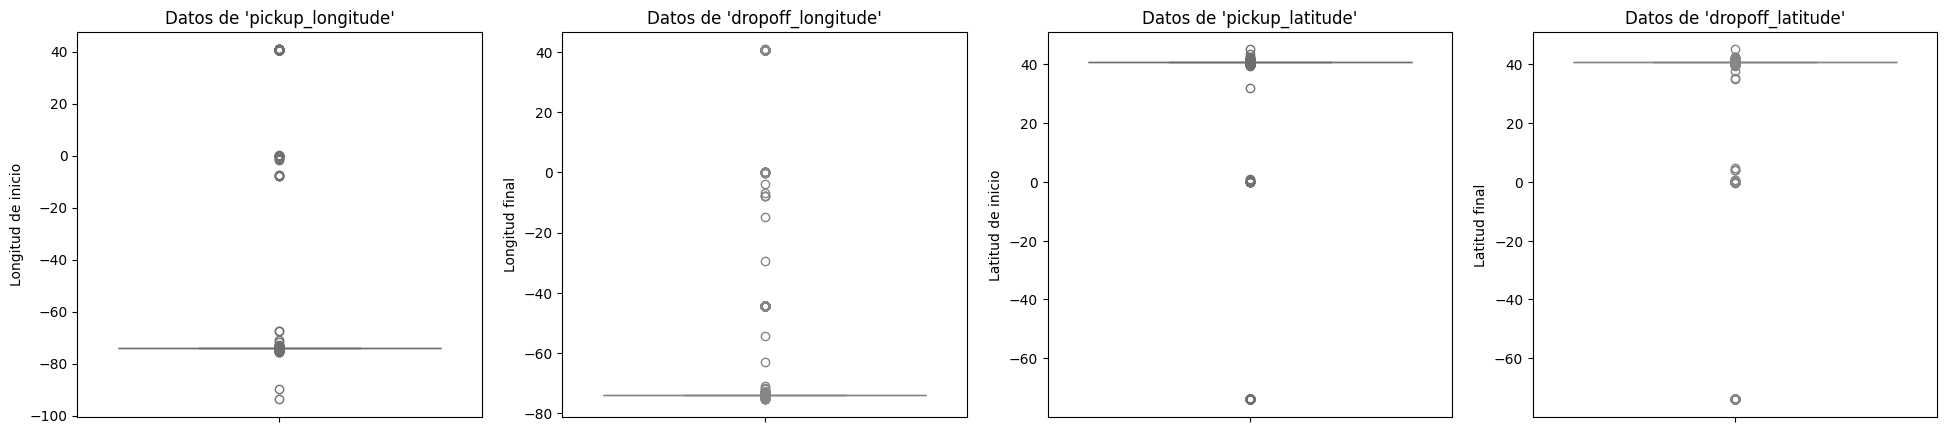

In [99]:
plt.figure(figsize=(24,5))

plt.subplot(1, 4, 1)
plt.title("Datos de 'pickup_longitude'")
sns.boxplot(X_train['pickup_longitude'], color="skyblue")
plt.ylabel('Longitud de inicio')


plt.subplot(1, 4, 2)
plt.title("Datos de 'dropoff_longitude'")
sns.boxplot(X_train['dropoff_longitude'], color="pink")
plt.ylabel('Longitud final')

plt.subplot(1, 4, 3)
plt.title("Datos de 'pickup_latitude'")
sns.boxplot(X_train['pickup_latitude'], color="skyblue")
plt.ylabel('Latitud de inicio')

plt.subplot(1, 4, 4)
plt.title("Datos de 'dropoff_latitude'")
sns.boxplot(X_train['dropoff_latitude'], color="pink")
plt.ylabel('Latitud final')

plt.show()

In [100]:
# Agregar mas caraterísticas a partir de las coordenadas geográficas
X_train["delta_lat"] = X_train["dropoff_latitude"] - X_train["pickup_latitude"]
X_train["delta_lon"] = X_train["dropoff_longitude"] - X_train["pickup_longitude"]

X_train["distance_km"] = X_train.apply(
    lambda row: haversine(
        row["pickup_longitude"], row["pickup_latitude"],
        row["dropoff_longitude"], row["dropoff_latitude"]
    ),
    axis=1
)
X_train.head()

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,delta_lat,delta_lon,distance_km
153248,2009-11-19 21:59:00+00:00,-73.978585,40.748388,-73.976913,40.784958,1,0.036570,0.001672,4.068836
67802,2013-02-27 22:29:15+00:00,-73.978198,40.752533,-73.909752,40.874372,1,0.121839,0.068446,14.721581
148889,2014-06-01 08:48:00+00:00,-73.994242,40.751227,-73.999432,40.762037,1,0.010810,-0.005190,1.279040
103093,2010-07-10 23:10:00+00:00,-73.951705,40.778330,-73.956050,40.777560,2,-0.000770,-0.004345,0.375743
104681,2013-09-29 13:36:00+00:00,-73.989120,40.736932,-73.782890,40.643947,1,-0.092985,0.206230,20.229696


In [101]:
X_train.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,delta_lat,delta_lon,distance_km
count,156964.000000,156964.000000,156964.000000,156964.000000,156964.000000,156964.000000,156964.000000,156964.000000
mean,-73.902184,40.685652,-73.877940,40.650702,1.688030,-0.034950,0.024245,9.045521
std,2.815343,2.692498,2.921796,2.945672,1.305204,1.230487,1.196027,176.304723
min,-93.824668,-74.015515,-75.458979,-74.015750,1.000000,-41.302596,-73.954419,0.000000
25%,-73.992264,40.736430,-73.991612,40.735203,1.000000,-0.014199,-0.011516,1.258108
50%,-73.982110,40.753277,-73.980498,40.753702,1.000000,0.000000,0.001018,2.163902
75%,-73.968364,40.767482,-73.965182,40.768341,2.000000,0.014290,0.013965,3.915607
max,40.808425,45.031653,40.831932,45.031598,6.000000,40.678675,73.999860,8667.693178


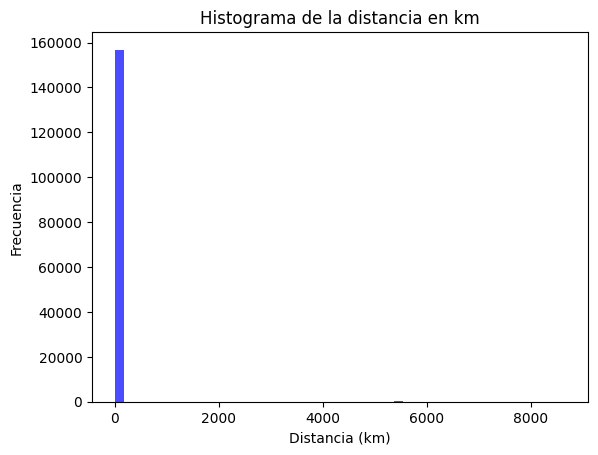

In [102]:
# histograma de la distancia en km

plt.hist(X_train['distance_km'], bins=50, color='blue', alpha=0.7)
plt.title('Histograma de la distancia en km')
plt.xlabel('Distancia (km)')
plt.ylabel('Frecuencia')
plt.show()


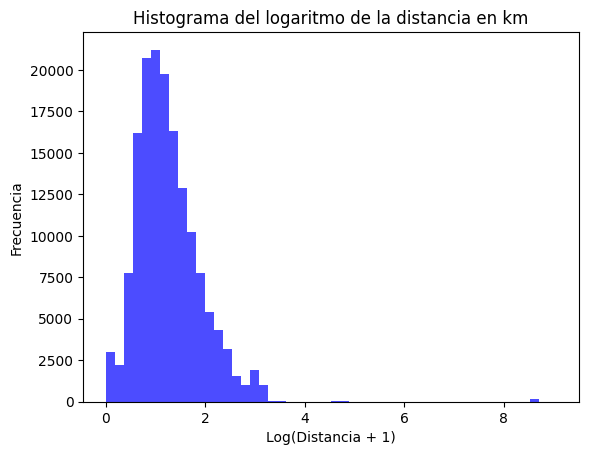

In [103]:
# histograma del logaritmo de la distancia en km
plt.hist(np.log1p(X_train['distance_km']), bins=50, color='blue', alpha=0.7)
plt.title('Histograma del logaritmo de la distancia en km')
plt.xlabel('Log(Distancia + 1)')
plt.ylabel('Frecuencia')
plt.show()


In [104]:
# calcular el primer cuartil (Q1) y el tercer cuartil (Q3)
Q1 = X_train['distance_km'].quantile(0.25)
Q3 = X_train['distance_km'].quantile(0.75)
IQR = Q3 - Q1
# definir los límites para los valores atípicos
lower_bound = Q1 - 5 * IQR
upper_bound = Q3 + 5 * IQR
print(f'Q1: {Q1}, Q3: {Q3}, IQR: {IQR}, Lower Bound: {lower_bound}, Upper Bound: {upper_bound}')

Q1: 1.2581079120066634, Q3: 3.915607113914761, IQR: 2.6574992019080974, Lower Bound: -12.029388097533824, Upper Bound: 17.203103123455247


In [105]:
# calcular la cantidad de valores atípicos
outliers = X_train[(X_train['distance_km'] < lower_bound) | (X_train['distance_km'] > upper_bound)]
print(f'Cantidad de valores atípicos: {outliers.shape[0]}')
print(f'Porcentaje de valores atípicos: {outliers.shape[0] / X_train.shape[0] * 100:.2f}%')

Cantidad de valores atípicos: 3266
Porcentaje de valores atípicos: 2.08%


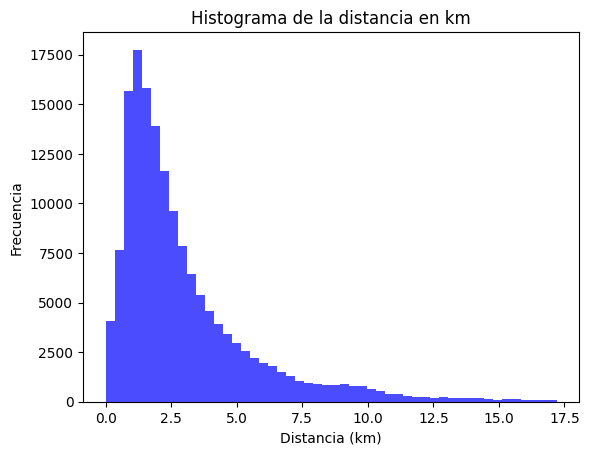

In [106]:
# obtener index de los datos para eliminar los valores atípicos
outlier_indices = outliers.index
# eliminar los datos atípicos de x_train y y_train
y_train = y_train.drop(outlier_indices)
X_train = X_train.drop(outlier_indices)


plt.hist(X_train['distance_km'], bins=50, color='blue', alpha=0.7)
plt.title('Histograma de la distancia en km')
plt.xlabel('Distancia (km)')
plt.ylabel('Frecuencia')
plt.show()


In [ ]:
y_train.describe()

Text(0, 0.5, 'Frecuencia')

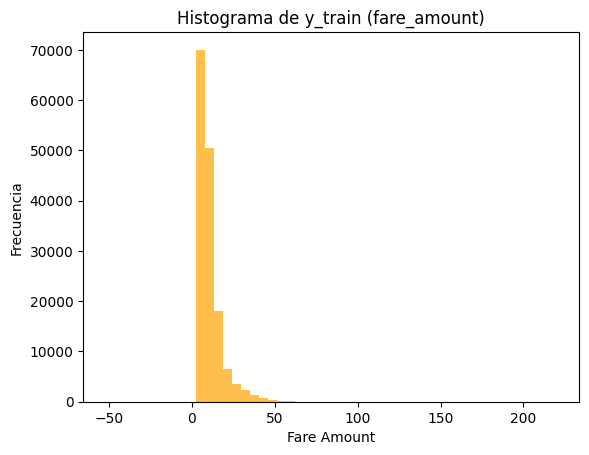

In [107]:
# histograma de y_train
plt.hist(y_train, bins=50, color='orange', alpha=0.7)
plt.title('Histograma de y_train (fare_amount)')
plt.xlabel('Fare Amount')
plt.ylabel('Frecuencia')        

In [108]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 153698 entries, 153248 to 121958
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   pickup_datetime    153698 non-null  datetime64[ns, UTC]
 1   pickup_longitude   153698 non-null  float64            
 2   pickup_latitude    153698 non-null  float64            
 3   dropoff_longitude  153698 non-null  float64            
 4   dropoff_latitude   153698 non-null  float64            
 5   passenger_count    153698 non-null  int64              
 6   delta_lat          153698 non-null  float64            
 7   delta_lon          153698 non-null  float64            
 8   distance_km        153698 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(7), int64(1)
memory usage: 11.7 MB


In [109]:
y_train.info()

<class 'pandas.core.series.Series'>
Index: 153698 entries, 153248 to 121958
Series name: fare_amount
Non-Null Count   Dtype  
--------------   -----  
153698 non-null  float64
dtypes: float64(1)
memory usage: 2.3 MB


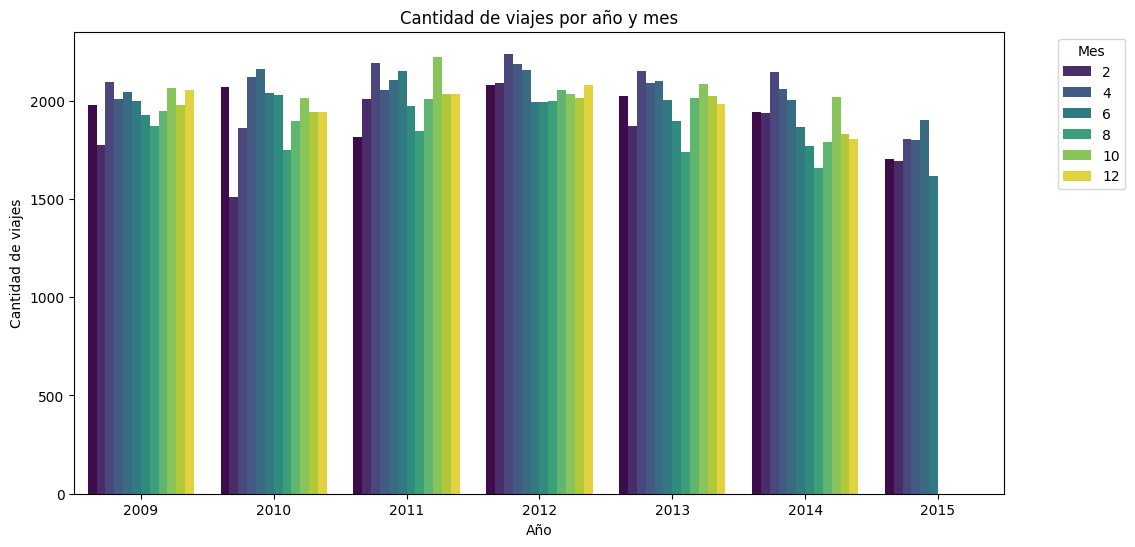

In [110]:
# mostrar cantidad de viajes por año y mes
X_train['pickup_year'] = X_train['pickup_datetime'].dt.year
X_train['pickup_month'] = X_train['pickup_datetime'].dt.month
# mostrar un grafico de barras con la cantidad de viajes por año y mes
plt.figure(figsize=(12,6))
sns.countplot(data=X_train, x='pickup_year', hue='pickup_month', palette='viridis')
plt.title('Cantidad de viajes por año y mes')
plt.xlabel('Año')
plt.ylabel('Cantidad de viajes')
plt.legend(title='Mes', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()  


In [111]:
# obtener el dia de la semana y la hora del dia a partir de pickup_datetime
X_train['pickup_day_of_week'] = X_train['pickup_datetime'].dt.dayofweek
X_train['pickup_hour'] = X_train['pickup_datetime'].dt.hour
X_train.head()

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,delta_lat,delta_lon,distance_km,pickup_year,pickup_month,pickup_day_of_week,pickup_hour
153248,2009-11-19 21:59:00+00:00,-73.978585,40.748388,-73.976913,40.784958,1,0.036570,0.001672,4.068836,2009,11,3,21
67802,2013-02-27 22:29:15+00:00,-73.978198,40.752533,-73.909752,40.874372,1,0.121839,0.068446,14.721581,2013,2,2,22
148889,2014-06-01 08:48:00+00:00,-73.994242,40.751227,-73.999432,40.762037,1,0.010810,-0.005190,1.279040,2014,6,6,8
103093,2010-07-10 23:10:00+00:00,-73.951705,40.778330,-73.956050,40.777560,2,-0.000770,-0.004345,0.375743,2010,7,5,23
80115,2011-07-03 01:37:00+00:00,-73.990852,40.751765,-73.978982,40.741775,3,-0.009990,0.011870,1.494608,2011,7,6,1


In [112]:
# agregar campo franja horaria a partir del campo pickup_hour
def franja_horaria(hora):
    if 0 <= hora < 6:
        return 'Madrugada'
    elif 6 <= hora < 12:
        return 'Mañana'
    elif 12 <= hora < 13:
        return 'Mediodia'
    elif 13 <= hora < 18:
        return 'Tarde'
    elif 18 <= hora < 24:
        return 'Noche'
    else:
        return 'Desconocido'
X_train['franja_horaria'] = X_train['pickup_hour'].apply(franja_horaria)
X_train.head()

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,delta_lat,delta_lon,distance_km,pickup_year,pickup_month,pickup_day_of_week,pickup_hour,franja_horaria
153248,2009-11-19 21:59:00+00:00,-73.978585,40.748388,-73.976913,40.784958,1,0.036570,0.001672,4.068836,2009,11,3,21,Noche
67802,2013-02-27 22:29:15+00:00,-73.978198,40.752533,-73.909752,40.874372,1,0.121839,0.068446,14.721581,2013,2,2,22,Noche
148889,2014-06-01 08:48:00+00:00,-73.994242,40.751227,-73.999432,40.762037,1,0.010810,-0.005190,1.279040,2014,6,6,8,Mañana
103093,2010-07-10 23:10:00+00:00,-73.951705,40.778330,-73.956050,40.777560,2,-0.000770,-0.004345,0.375743,2010,7,5,23,Noche
80115,2011-07-03 01:37:00+00:00,-73.990852,40.751765,-73.978982,40.741775,3,-0.009990,0.011870,1.494608,2011,7,6,1,Madrugada


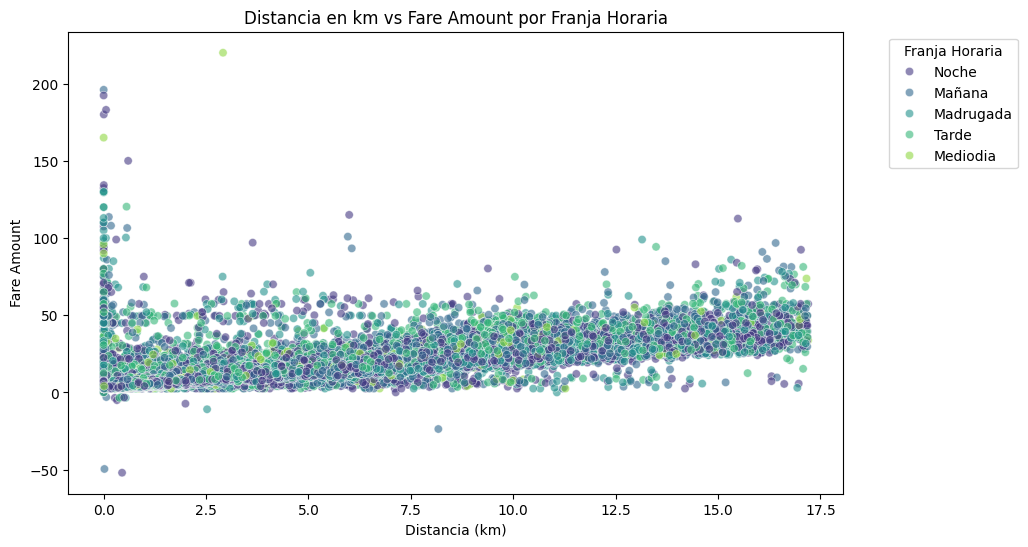

In [114]:
# mostrar un scatter plot de la distancia en km vs fare_amount, color franja horaria
plt.figure(figsize=(10,6))
sns.scatterplot(data=X_train, x='distance_km', y=y_train, hue='franja_horaria', palette='viridis', alpha=0.6)
plt.title('Distancia en km vs Fare Amount por Franja Horaria')
plt.xlabel('Distancia (km)')
plt.ylabel('Fare Amount')
plt.legend(title='Franja Horaria', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()



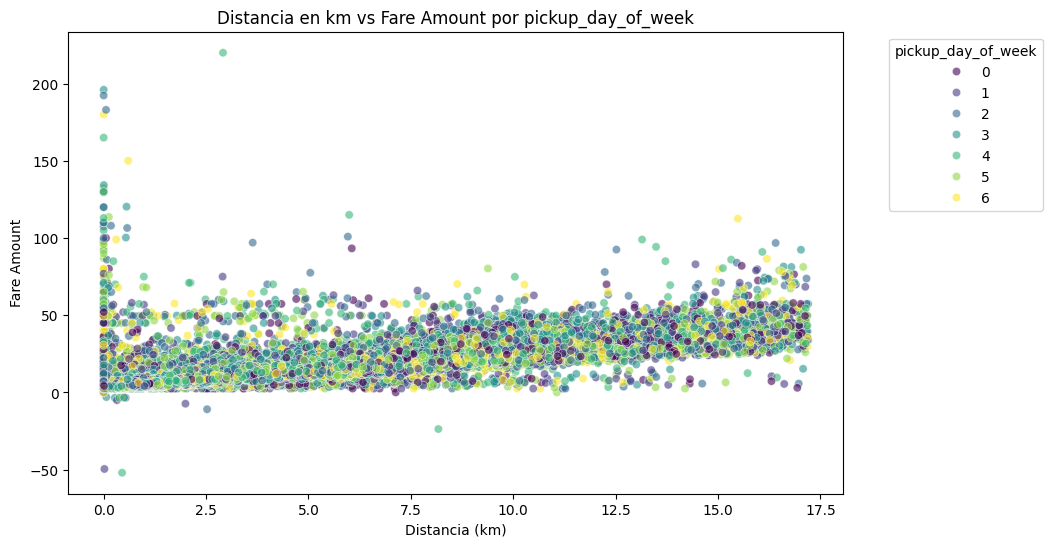

In [115]:
# mostrar un scatter plot de la distancia en km vs fare_amount, color dia de la semana
plt.figure(figsize=(10,6))
sns.scatterplot(data=X_train, x='distance_km', y=y_train, hue='pickup_day_of_week', palette='viridis', alpha=0.6)
plt.title('Distancia en km vs Fare Amount por pickup_day_of_week')
plt.xlabel('Distancia (km)')
plt.ylabel('Fare Amount')
plt.legend(title='pickup_day_of_week', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()